In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
# from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

from encoders import Encoder
from aggregators import MeanAggregator

Using matplotlib backend: agg


In [2]:
"""

GraphSAGE without Neighboring Sampling

"""

class SAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, normalize=False, bias=True):
        super(SAGEConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.linear = torch.nn.Linear(self.in_channels, out_channels, bias=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
            torch.nn.init.zeros_(self.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = out / adj.sum(dim=-1, keepdim=True).clamp(min=1)
        out = self.linear(out)

        if self.bias is not None:
            out = out + self.bias

        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_dim, 16)
        self.conv2 = SAGEConv(16, out_dim)

    def forward(self, data):
        x, adj = data.x, data.adj
        
        x = self.conv1(x, adj)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, adj)

        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
tolerance = 1.00

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data

# random sampling edges
frac = 0.1
num_edges = data.edge_index.size(1)
perm = torch.randperm(num_edges)
idx = perm[:int(frac * num_edges)]
new_edge_index = data.edge_index[:, idx]

# using sparse graph
# data.adj = to_dense_adj(add_self_loops(new_edge_index)[0])[0]
data.adj = torch.zeros(data.x.size(0), data.x.size(0))
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

In [4]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > 2 * early_stop_win_size:
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
        if val_acc_current < val_acc_previous - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.14285714285714285 , loss = 1.9459106922149658
1000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
2000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
3000 training acc = 0.14285714285714285 , loss = 1.9459102153778076
4000 training acc = 0.14285714285714285 , loss = 1.9459099769592285
5000 training acc = 0.14285714285714285 , loss = 1.9459099769592285
6000 training acc = 0.14285714285714285 , loss = 1.9459104537963867
7000 training acc = 0.14285714285714285 , loss = 1.9459099769592285
8000 training acc = 0.14285714285714285 , loss = 1.9459102153778076
9000 training acc = 0.14285714285714285 , loss = 1.9459102153778076


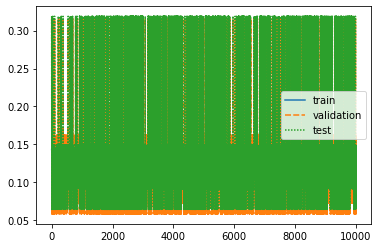

In [5]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [6]:
spio.savemat('../variables/' + name + '/SAGEConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [7]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 0.1429
Validation Accuracy: 0.1140
Test Accuracy: 0.1030


In [8]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.5000


In [10]:
# 0% links
test_acc_all = np.array([0.1300, 0.1440, 0.1030, 0.1030, 0.1030])
test_auc_all = np.array([0.5000, 0.5000, 0.5000, 0.5000, 0.5000])

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.1166
0.5
0.01723484841824842
0.0


In [11]:
true_index = data.edge_index.cpu().numpy().T

start = true_index[:, 0]

unq_val, unq_idx = np.unique(start, return_index=True)
start_dict = dict(zip(unq_val, unq_idx))

In [16]:
def random_choice_noreplace(m,n, axis=-1):
    return np.random.rand(m,n).argsort(axis=axis)

rand_index = random_choice_noreplace(num_edges, num_edges, axis=-1)[:2]

In [18]:
print(pred_index.shape)
pred_index = np.unique(rand_index, axis=1)
print(pred_index.shape)

(2, 10556)
(2, 10556)


In [19]:
correct_list = []
for i in range(len(pred_index)):
    pred = pred_index[i]
    if pred[0] in start_dict:
        begin = start_dict[pred[0]]
        if pred[0] + 1 in start_dict:
            end = start_dict[pred[0] + 1]
        else:
            end = len(true_index)
    for j in range(begin, end):
        true = true_index[j]
        if np.array_equal(pred, true):
            print(i, j, pred, true)
            correct_list.append((i, pred))
            break